# Homework 5 - Bonus question

Here we will compute the sentiment coming from the email per country. 

In [26]:
## Importation of useful libraries
import pycountry
import pandas as pd
import numpy as np
import os
import seaborn as sns
import datetime
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank
import operator
from operator import itemgetter
import networkx as nx
import community
%matplotlib inline

<h3>Data loading and cleaning</h3>

We will first load the data, and then clean them. We decided to use the "ExtractedBodyText" for this part, therefore we will drop all the empty cells.

In [3]:
filename = os.path.join('hillary-clinton-emails','Emails.csv')
df_email = pd.read_csv(filename)
df_email = df_email.dropna(axis=0, how='any', subset=['ExtractedBodyText'])
df_email.head(2)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...


 To clean the data, we use exactly the same technique as in exercice 1. Therefore, we decided to export this technique to an external function, and just use the function. All the explanations can be found in exercice 1 of the homework. This function will return a map between the indices of the email dataframe and a list of token (coming from the email of the indice)

In [4]:
## Cleaning data with the external script.
## map : (mail index -> list of tokens)
from cleaningData import getTokenMapFromData
map_mail_index_to_token_list = getTokenMapFromData(False)

Starting to import data
Starting cleaning...
Creating tokens...
list token len= 6742
list index len= 6742
Finished!


In [5]:
print('-- Dataframe: ')
print(df_email.ExtractedBodyText[1])
print('-- Token list : ')
print(map_mail_index_to_token_list[1])

-- Dataframe: 
B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
March 3, 2011
For: Hillary
-- Token list : 
['B6', 'H', 'Latest', 'How', 'Syria', 'aiding', 'Qaddafi', '', 'Sid', 'hrc', 'memo', 'syria', 'aiding', 'libya', '030311.docx', 'hrc', 'memo', 'syria', 'aiding', 'libya', '030311.docx', 'March', '3', '2011', 'For', 'Hillary']


Importing receiver data

In [32]:
## Import receiver data
receiver_filename = os.path.join('hillary-clinton-emails','EmailReceivers.csv')
receiverdf = pd.read_csv(receiver_filename)
receiverdf.head(2)

,Id,EmailId,PersonId
0,1,1,80
1,2,2,80


Importing the alias data linking a personId to its different aliases.

In [17]:
## Import person data
persons_filename = os.path.join('hillary-clinton-emails','Aliases.csv')
persons_df = pd.read_csv(persons_filename)
persons_df.head(2)

,Id,Alias,PersonId
0,1,111th congress,1
1,2,agna usemb kabul afghanistan,2


We will make a map between the id of an email and its sender.

In [7]:
email_senders_map = {}

def makeEmailSendersMap(row):
    senderId = row.SenderPersonId
    if not np.isnan(senderId):
        email_senders_map[row.Id] = int(senderId)

In [8]:
df_email.apply(makeEmailSendersMap, axis=1)
print('Map between email and senders done.')

Map between email and senders done.


<h3>Communication graph</h3>

Now, let's create iteratively the first graph of the receivers and senders.

In [11]:
sendReceiveGraph = nx.Graph()

def createGraphWithReceivers(row):
    email_id = row.EmailId
    receiver_id = row.PersonId
    if email_id and receiver_id and email_senders_map.get(email_id):
        send_id = email_senders_map[email_id]
#         sendReceiveGraph.node[send_id] =
        sendReceiveGraph.add_edge(send_id, receiver_id, {'email_id':email_id})

We will apply the method to all the receiver and complete therefore the graph sendReceiveGraph.

In [12]:
receiverdf.apply(createGraphWithReceivers, axis=1)
print('Graph creation finished.')

Graph creation finished.


Let's take a look at the first vertices by degree order.

In [27]:
sorted(sendReceiveGraph.degree_iter(),key=itemgetter(1),reverse=True)[:5]

[(80, 307), (81, 69), (32, 66), (87, 40), (105, 21)]

So, we know that the most connected persons have the id: [80, 81, 32, 87].<br>
To add interesting information to the graph, we found out the name of these nodes (using the Alias information) and added them to the graph.

In [58]:
persons_df[persons_df.PersonId == 32].head(2)

,Id,Alias,PersonId
55,56,c:mills cheryl,32
56,57,cheryl mills,32


In [51]:
labels = {80:'Hillary\nClinton', 81:'Huma\nAbedin', 32:'Cheryl\n Mills', 87:'Jake\nSullivan'}

Now we can plot the graph of all the vertices, increasing the size of a vertice depending on its degree.

Receiver/senders graph:


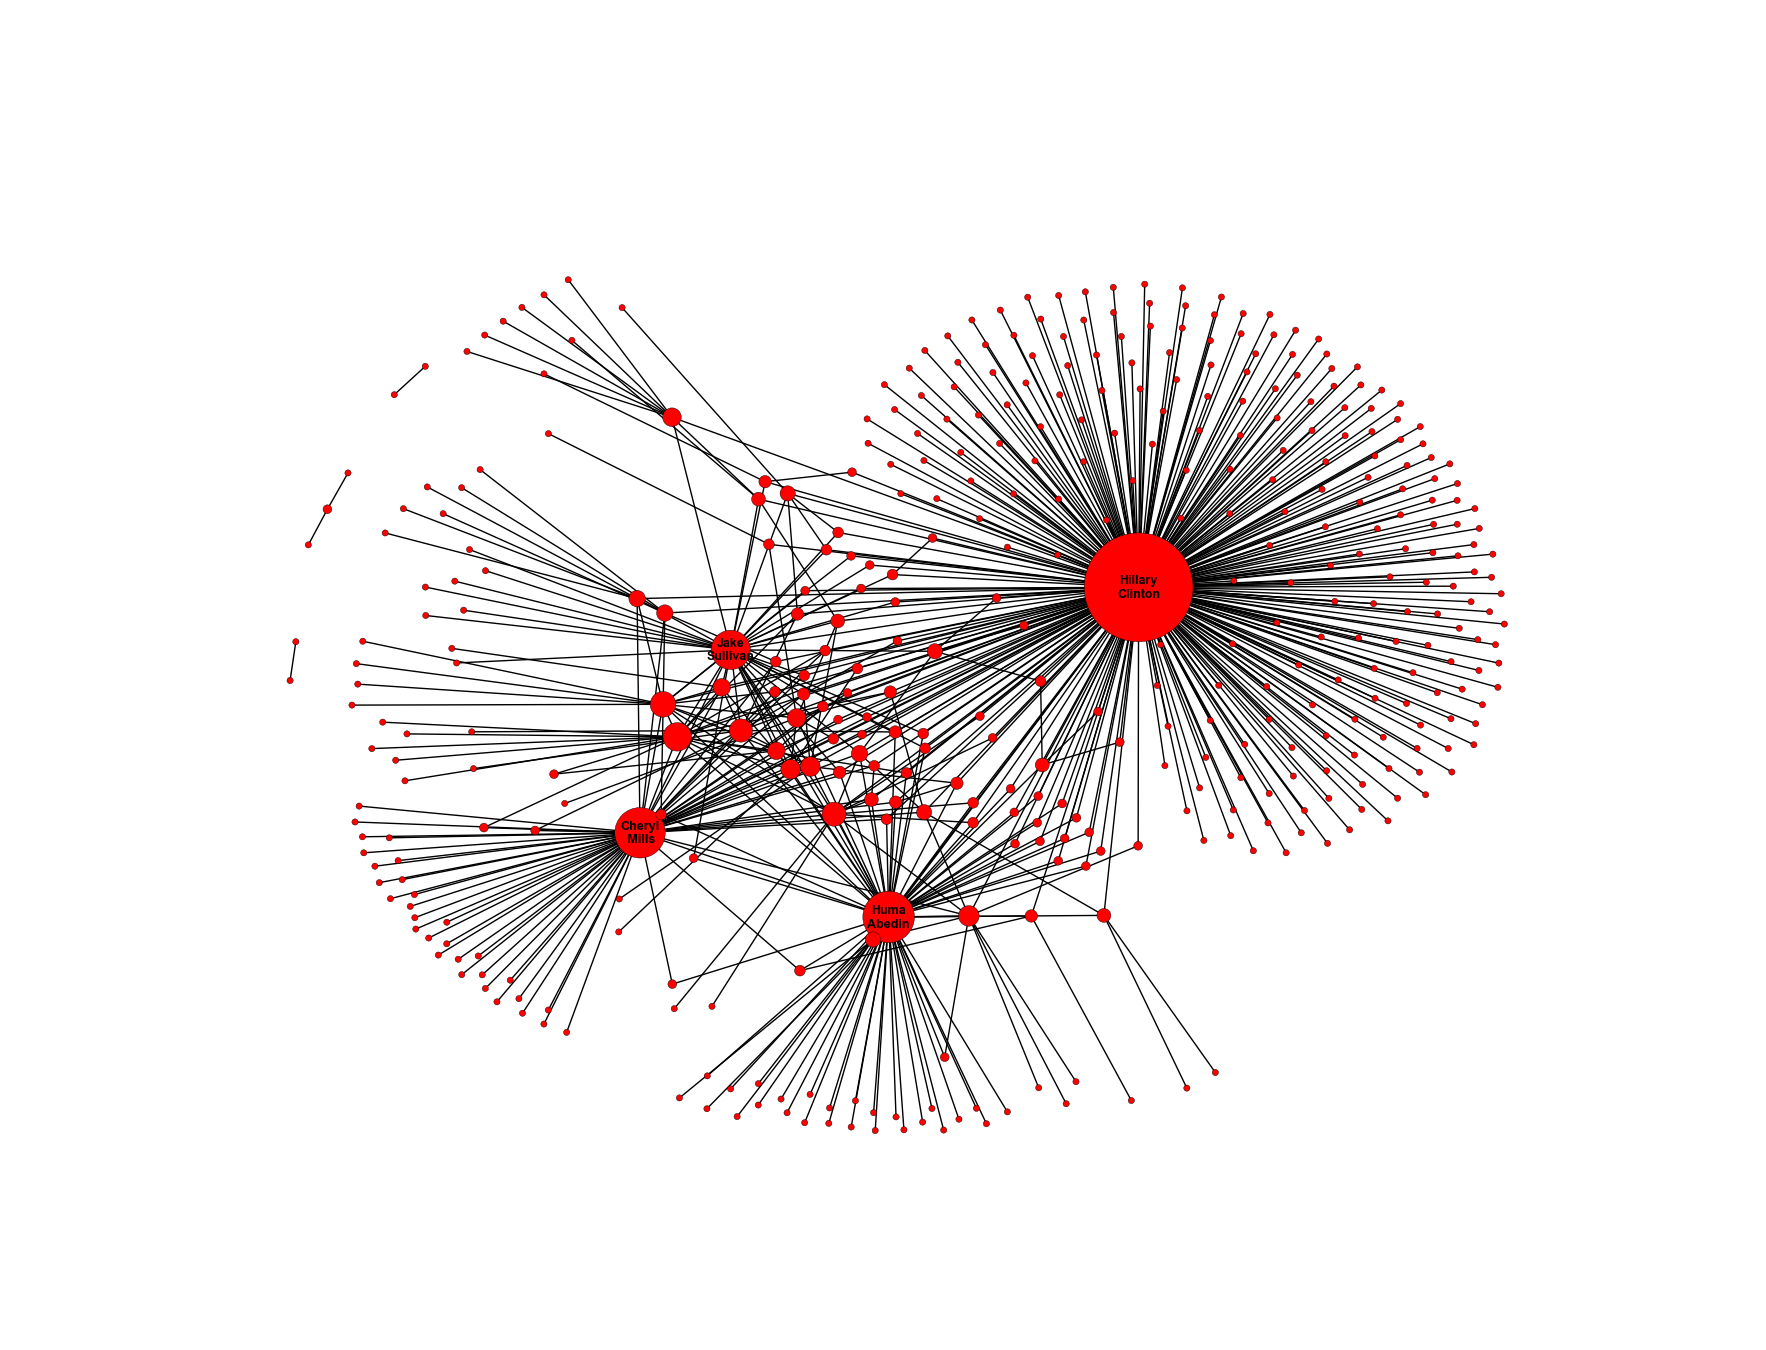

In [57]:
plt.figure(figsize=(17,13))
d = nx.degree(sendReceiveGraph)
pos = nx.spring_layout(sendReceiveGraph)
nx.draw(sendReceiveGraph, pos=pos, nodelist=d.keys(), node_color='red', with_labels=False, node_size=[v * 20 for v in d.values()])
nx.draw_networkx_labels(sendReceiveGraph,pos, labels,font_size=9, font_color='black', font_weight='bold')
print('Receiver/senders graph:')

We can observe that the biggest nodes in the graph are Hillary Clinton, and people important in her environment. Huma Abedin was chief of staff of Hillary, Jake Sullivan was deputy Chief of Staff and Cheryl Mills was Counselor and Chief of Staff when Hillary Clinton was secretary of states.

<h3>Best partition for sender/receiver</h3>

Let's make a best partition of the data.

In [62]:
partition = community.best_partition(sendReceiveGraph)

Now, we can plot this partition of the data.

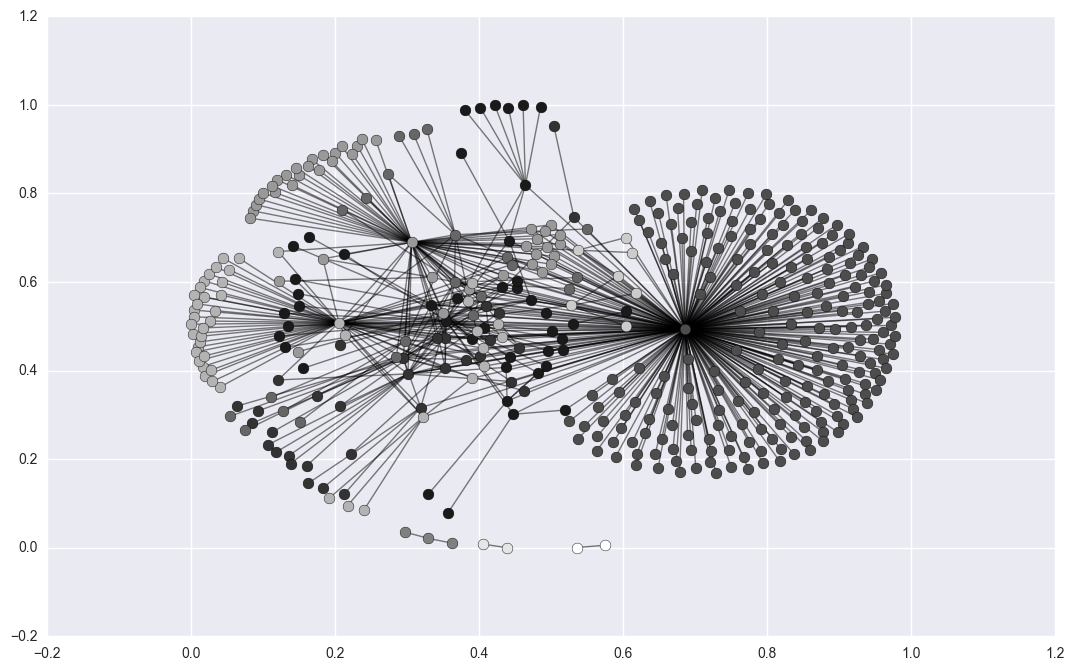

In [63]:
plt.figure(figsize=(13,8))
size = float(len(set(partition.values())))
pos = nx.spring_layout(sendReceiveGraph)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(sendReceiveGraph, pos, list_nodes, node_size = 60,
                                node_color = str(count / size))


nx.draw_networkx_edges(sendReceiveGraph,pos, alpha=0.5)
plt.show()

In [70]:
print('The partition is splitted in',len(set(partition.values())),'different communities.')

The partition is splitted in 10 different communities.


<h3>Most frequent words per community</h3>

Now, we will get the 20 most frequent words per partition. We will construct a map with the partition id as key, and as value a dictionary with each token as key, and its occurence as value.

In [76]:
partitionMailMap = {}  ## map between: {partition id -> { token -> occurence}}

## map initialized
for i in range(0,len(set(partition.values()))):
    partitionMailMap[i] = {}

    
def addMailWordsToPartition(row):
    '''
    This function is to be applied to each row of the emails dataframe.
    For each email, it will look at the sender, and take its corresponding map in the partitionMailMap
    Then, it will take the list of tokens of the email, and add 1 to its occurence value.
    '''
    senderId = row.SenderPersonId
    if not np.isnan(senderId) and partition.get(senderId):
        partitionNum = partition[senderId]
        tokenlist = map_mail_index_to_token_list[row.name]
        for token in tokenlist:
            if partitionMailMap[partitionNum].get(token):
                partitionMailMap[partitionNum][token] += 1
            else:
                partitionMailMap[partitionNum][token] = 0
                
                
def getMostUsedWordsOfDictionary(token_dict):
    '''
    Get the 20 most used words in the give token to occurence dictionary.
    Input: Dictionary : {token -> occurence}
    Output: List[token_1, token_2, ..., token_20] with occurence(token_i) > occurence(token_j) for i > j
    '''
    return heapq.nlargest(20, token_dict, key=token_dict.get)

Now, let's compute the dictionary for each community.

In [78]:
df_email.apply(addMailWordsToPartition, axis=1)
print('Dictionary computed.')

Dictionary computed.


In [80]:

print('We will have', len(set(partition.values())), 'communities.')
for partition_id in partitionMailMap:
    print('Community', partition_id,':')
    most_used_words_list = getMostUsedWordsOfDictionary(partitionMailMap[partition_id])
    print(most_used_words_list)
#     for word in most_used_words_list:
#         print(word)

We will have 10 communities.
Community 0 :
[]
Community 1 :
['', 'Remove', 'recruits', 'OKs', 'magnitude', 'SABC-International', 'backwards', '4am', 'recent', 'deep', 'identify', 'husbands', 'cdnt', 'unconfirmed', 'immensely', 'Abdul', 'Koltai', 'inadequate', 'engine', 'gained']
Community 2 :
['', 'mew', 'Cairo', 'T1CS', 'Competitive', 'Pay', 'recent', 'websites', 'deep', 'driven', '05:35:25', 'fore', 'scared', 'Expeditionary', 'Sixteen', 'negotiations—but', 'exports', 'dir', '647-2645', 'nailed']
Community 3 :
['', 'message', 'simpler', 'TAIWAN', 'recent', 'deep', 'ROSEMARIE', 'ANGELA', '4:15', 'pmS', 'pmU.S', '7:30', '58-41', 'But', 'learn', 'w/CAMBODIAN', 'click', 'emotions', 'sale', 'LICHTENSTEIN']
Community 4 :
['', 'do', 'tshirts', 'INGOs', 'fatigue', 'deep', 'encourage', 'organizing', 'apparently', 'told', 'contrast', 'UN', 'diarrhea', 'asked', 'Farmer', 'group', 'cars', 'teachers', 'work', 'clear']
Community 5 :
['', 'Joyce', 'message', 'edits', 'sen', 'catholic', 'recent', 'ka

So firstly we have a community where we can not find an email (community 0), it is probably because it doesn't contain a lot of members and the email information must be empty.

For community 1, it could be people in the military or about operations. We have the words "recruits",  "identify", "cdnt", "unconfirmed" that sounds "military".<br>
Community 4 could be about people living foreign of the USA. We have "fatigue". "encourage", "UN", "diarrhea", "farmer", "teachers", etc.. that could lead to think that they are in a third world country.<br>
Community 7 could be about relationship/development of companies: "Board", "development", "encourage", "funds", "pharma", etc.. that could lead to think that.

We have mostly different results than the LDA of exercice 3. However, some words of a few community (like the 4 and 6) look similar than what we got. It looks logical to find similarity, as a community will often discuss about the same subject (that will be their job usually).

Finally, we observe that it is hard to tell with just the top 20 words of a community what this community is about. However, this is an incredible tool that, associated with other tools, could really help understanding better the data.